In [1]:
# Peter Nelson 30/9/19
# Code for use at the FASTBLADE facility, determining where to place hydraulic rams to best simulate desired loading on 
# testing specimen. This code has different modes for different inputs. One mode uses target shear & bending data and the
# other modes use only either target load, shear or bending data. The code uses a genetic algorithm to solve an objective
# function that is minimised when the difference between the desired and actual shear force distributions is at a global 
# minimum. The code implicitly ensures that the desired bending moment distribution is simulated by ensuring that the sum 
# of ratios required is achieved. The code also accepts inputs for how many rams are present in the sytem and upper and 
# lower bounds for ram positions.

# modularisable and adaptable elsewhere more than Jupyter

# Start

In [48]:
import pandas as pd
import numpy as np

data = pd.read_excel(r"C:\Users\Peter's 2nd Laptop\Documents\MATLAB\FB again\Matlab Code No Contraints\testdata.xlsx")

number_rams = 4
nodes = 1000
lower_b = 0.05
upper_b = 0.95

# Interpolation

In [49]:
L = data['radial position'][len(data)-1]

x = list(range(0,nodes))
b = L/(nodes-1)
x[:] = [ __ * b for __ in x]

Fx = np.interp(x,data['radial position'],data['Fx'])
Fy = np.interp(x,data['radial position'],data['Fy'])      #read about interpolation method

# Defining Targets

In [50]:
import scipy, numpy 
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline  

integralpart = scipy.integrate.cumtrapz(Fx, x)
integralpart = np.insert(integralpart,0,0)
TF = integralpart[-1]

TargetShear = [None]*len(Fx)
TargetShear[0] = TF
TargetShear[-1] = 0

for k in range(2,len(integralpart)):
    TargetShear[k-1] = TF-integralpart[k-1]

integralPart = scipy.integrate.cumtrapz(TargetShear,x)
integralPart = numpy.insert(integralPart,0,0)
bmax = integralPart[-1]

TargetBending = [None]*len(Fx)
TargetBending[0] = -bmax
TargetBending[-1] = 0

for k in range(1,len(integralPart)):
    TargetBending[k] = integralPart[k]-bmax

In [51]:
F = TF/number_rams;
SumRatios = number_rams*(max(map(abs, TargetBending)))/max(TargetShear)/L

# Actual Shear & Bending

In [52]:
def AcSh(sol):
    
    if sol[-1] != L:
        sol = np.append(sol,L)
    
    ActualShear = [TF]*len(x)

    for i in range(0,len(x)):
        for j in range( 0,len(sol)-1):
            if x[i] > sol[j]:
                ActualShear[i] = ActualShear[i]-F

    return(ActualShear)

In [53]:
def AcBe(AcSh):
    ActualShear = AcSh
    
    integralPart = scipy.integrate.cumtrapz(ActualShear,x)
    integralPart = numpy.insert(integralPart,0,0)
    bmax = integralPart[-1]
    
    ActualBending = [None]*len(Fx)
    ActualBending[0] = -bmax
    ActualBending[-1] = 0

    for k in range(1,len(integralPart)):
        ActualBending[k] = integralPart[k]-bmax
    
    return(ActualBending)

# Objective

In [54]:
def obj(sol):
    
    if len(sol) != number_rams:
        print('wrong number of rams')
        
    else:  
        sol = np.append(sol,L)
    
        lsq_l = [None]*(len(x))
        ActualShear = AcSh(sol)
        for i in range(0,len(x)):
            lsq_l[i] = abs(ActualShear[i]-TargetShear[i])
        return sum(lsq_l)

# Solver

In [55]:
import datetime # can remove at some point

bounds = [(lower_b*L, upper_b*L)]*number_rams

before = datetime.datetime.now()  
solfinal = scipy.optimize.dual_annealing(obj,bounds)  # consider random state since same obj func found
after = datetime.datetime.now()
print(after-before)

# solfinal=scipy.optimize.differential_evolution(obj,bounds,maxiter=10000,popsize=120,tol=0.001,mutation=(0.5,1.9))
# solfinal=scipy.optimize.brute(obj,bounds)
# other one is terrible

n = np.sort(solfinal.x)
print(n)

0:03:05.625978
[ 658.73729652 2014.10938653 3530.89776256 5566.51173246]


# Results

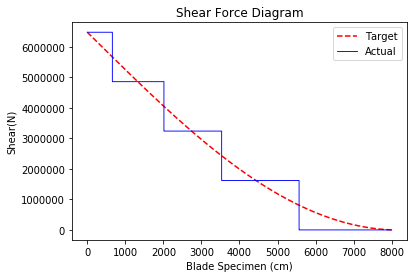

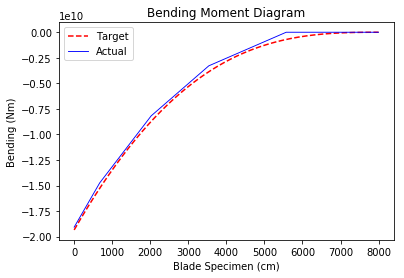

In [66]:
import matplotlib.pyplot as plt

ActualShear = AcSh(n)
ActualBending = AcBe(ActualShear)

plt.plot(x, TargetShear,'r', label = 'Target',ls='--')
plt.step(x, ActualShear, 'b', label = 'Actual', where='post',lw=0.9)
plt.xlabel('Blade Specimen (cm)')
plt.ylabel('Shear(N)')
plt.title('Shear Force Diagram')
plt.legend(loc='best')
# plt.savefig('ShearForceDiagram.png')
plt.show()

plt.plot(TargetBending, 'r', label = 'Target',ls='--')
plt.plot(ActualBending, 'b', label = 'Actual',lw=0.9)
plt.xlabel('Blade Specimen (cm)')
plt.ylabel('Bending (Nm)')
plt.title('Bending Moment Diagram')
plt.legend(loc='best')
# plt.savefig('BendingMomentDiagram.png')
plt.show()

# Exporting to Excel

In [ ]:
#how to export solution of where rams are acting???

In [36]:
d = {'Nodes':x,'TargetShear':TargetShear,'ActualShear':ActualShear,'TargetBending':TargetBending,'ActualBending':ActualBending}
df = pd.DataFrame(data=d)
df.to_csv('newcsv.csv', index= False)

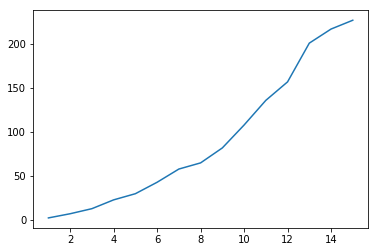

In [189]:
#when 1000 nodes are used
ramcount=[1,   2,   3,  4,  5,  6,   7,  8,  9,  10,  11, 12,  13,  14,   15 ]
seconds=[2.5, 7.25, 13, 23, 30, 43, 58, 65, 82, 108, 136, 157, 201, 217, 227]


fig, ax = plt.subplots()
ax.plot(ramcount, seconds)

In [170]:
[ 874.07631605 2738.02712263 5147.34189695]

SyntaxError: invalid syntax (<ipython-input-170-5440f75f0c37>, line 1)

In [128]:
a=obj(n)
print(a)
print((488657228.6544505-a)/a)

488658675.91768974
-2.9617058093700295e-06


In [129]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

In [ ]:
store=[]

for zz in range(0,4000,1):
    sol=[zz,5500,7500]
    value=obj(sol)
    store=np.append(store, value)
    
    
len(store)
import matplotlib.pyplot as plt
%matplotlib inline  
    
plt.plot(store)